In [1]:
import divand
using PyPlot

# Reading data as before

In [37]:
varname = "Salinity"
filename = "WOD-Salinity-Provencal.nc"


if !isfile(filename)    
    download("https://b2drop.eudat.eu/s/UsF3RyU3xB1UM2o/download",filename)
end

value,lon,lat,depth,obstime,ids = divand.loadobs(Float64,filename,"Salinity");

# Topography and grid definition. 

See other notebook for explanation. Here just code replicated to get topography defining the mask

In [3]:
dx = dy = 0.125/2.
lonr = 2.5:dx:12.
latr = 42.3:dy:44.6

mask,(pm,pn),(xi,yi) = divand.divand_rectdom(lonr,latr)

bathname = "gebco_30sec_4.nc"




if !isfile(bathname)
    download("https://b2drop.eudat.eu/s/ACcxUEZZi6a4ziR/download",bathname)
else
    info("Bathymetry file already downloaded")
end


bx,by,b = divand.load_bath(bathname,true,lonr,latr)



mask = falses(size(b,1),size(b,2))


    for j = 1:size(b,2)
        for i = 1:size(b,1)
        mask[i,j] = b[i,j] >=1.0
        end
    end


INFO: Bathymetry file already downloaded


# Data selection for example

Cross validation, error calculations etc assume independant data. Hence do not take high resolution vertical profiles with all data but restrict yourself to specific small depth range. Here August data at surface:

In [38]:
sel = (depth .< 1) .& (Dates.month.(obstime) .== 8)

value = value[sel]
lon = lon[sel]
lat = lat[sel]
depth = depth[sel]
obstime = obstime[sel]
ids = ids[sel];
@show (size(value))
divand.checkobs((lon,lat,depth,obstime),value,ids)

size(value) = (1956,)
              minimum and maximum of obs. dimension 1: (3.0763332843780518, 11.779999732971191)
              minimum and maximum of obs. dimension 2: (42.0, 44.0)
              minimum and maximum of obs. dimension 3: (0.0, 0.9921539425849915)
              minimum and maximum of obs. dimension 4: (1910-08-09T00:00:00, 2014-08-28T19:36:00)
                          minimum and maximum of data: (24.886999130249023, 39.18000030517578)


# Analysis

Analysis parameters have been calibrated in the other notebook example. WARNING: if the statistical parameters are incorrectly estimated, the error fields are meaningless and only provide an idea of data coverage.

In [ ]:
len=0.3
epsilon2=1

Analysis fi using mean data as background. Strucure s is stored for later use in error calculation

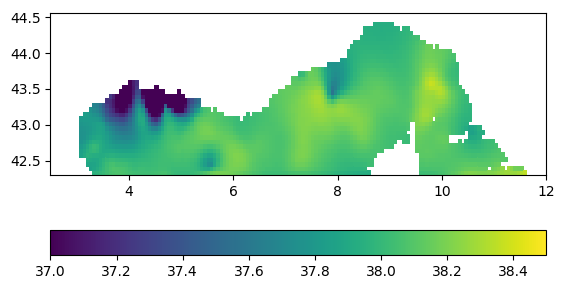

In [18]:
fi,s = divand.divandrun(mask,(pm,pn),(xi,yi),(lon,lat),value-mean(value),len,epsilon2);
pcolor(xi,yi,fi+mean(value),vmin=37,vmax=38.5);colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))

## Exact error and approximations


Approximate and Efficient Methods to Assess Error Fields in Spatial Gridding with Data Interpolating Variational Analysis (DIVA) Beckers, Jean-Marie; Barth, Alexander;  Troupin, Charles, Alvera-Azcarate, A.  Journal of Atmospheric & Oceanic Technology (2014), 31(2), 515-530, https://orbi.uliege.be/handle/2268/161069 https://journals.ametsoc.org/doi/abs/10.1175/JTECH-D-13-00130.1


In the 2D case you can try to calculate the exact error expression. This demands the computationally expensive evaluation of diag(s.P) accessible via the analysis returned structure s. Only available with divandrun.

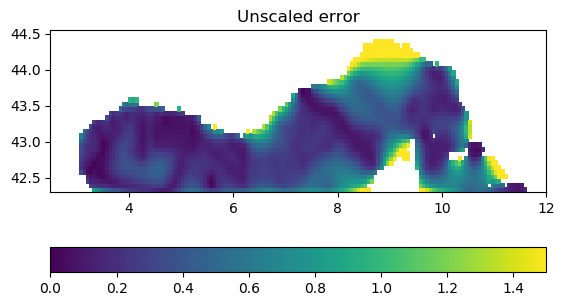

PyObject Text(0.5,1,u'Unscaled error')

In [27]:
exerr,=divand.statevector_unpack(s.sv,diag(s.P))
exerr[find(x -> x == false,mask)]=NaN

pcolor(xi,yi,exerr,vmin=0, vmax=1.5);colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
title("Unscaled error");

Relative error by scaling with background variance Berr estimated using data with high errors

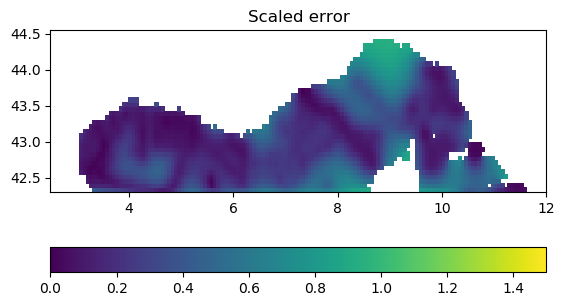

In [29]:
epsilon2huge=1E6
fib,sb = divand.divandrun(mask,(pm,pn),(xi,yi),(lon,lat),value,len,epsilon2huge);
Berr,=divand.statevector_unpack(sb.sv,diag(sb.P))

pcolor(xi,yi,exerr./Berr,vmin=0, vmax=1.5);colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
title("Scaled error");

Now clever poor man's error. Useage as for divandrun

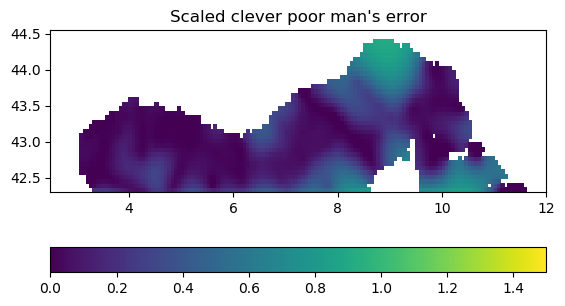

In [30]:
cpme=  divand.divand_cpme(mask,(pm,pn),(xi,yi),(lon,lat),value,len,epsilon2)

pcolor(xi,yi,cpme,vmin=0, vmax=1.5);colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
title("Clever poor man's error");


Do you see any difference between the exact and clever poor man's error ? 

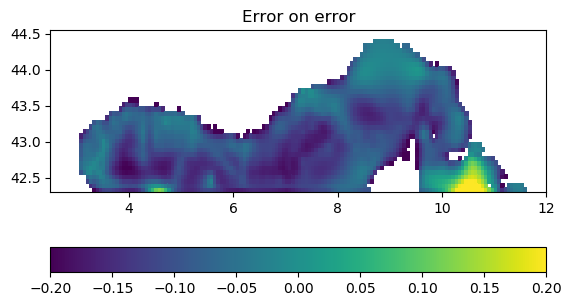

In [36]:
pcolor(xi,yi,cpme-exerr./Berr,vmin=-0.2, vmax=0.2);colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
title("Error on error");

Another approximation to the error field: AEXERR

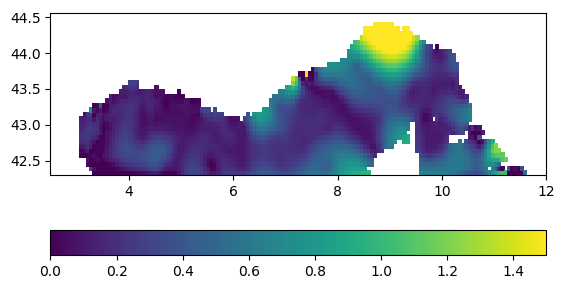

typeof(Rfake) = Diagonal{Float64}
issubtype(typeof(Rfake), Union{AbstractArray{Float64, 1}, AbstractArray{Float64, 2}}) = true


In [22]:
myerr,bjmb,fa,sa=  divand.divand_aexerr(mask,(pm,pn),(xi,yi),(lon,lat),value,len,epsilon2)
if myerr==0
    error("No need to approximate error, use direct calculation")
else
    pcolor(xi,yi,myerr,vmin=0, vmax=1.5);colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
    title("Unscaled almost exact error");
end

Scaled AXERR error

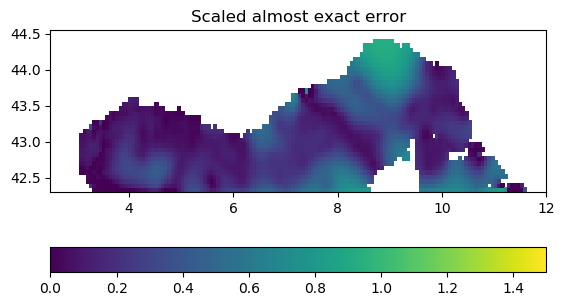

PyObject Text(0.5,1,u'Scaled almost exact error')

In [31]:
if myerr==0
    error("No need to approximate error, use direct calculation")
else
    pcolor(xi,yi,myerr./bjmb,vmin=0, vmax=1.5);colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
    title("Scaled almost exact error");
end

Conclusion: In view of the uncertainties on statistical parameters (L, $\epsilon^2$), the clever poor man's error is generally a sufficient approximation for the error fields. This is the one implemented in the divandgo high-level analysis function. 